# Курс "Аналитик данных" PROJECT-3. Решение комплексной бизнес-задачи 

## ЦЕЛИ ИССЛЕДОВАНИЯ ПРОЕКТА:


1. **Построить рекомендательную систему** , благодаря которой можно будет предлагать клиентам интересные им курсы. Для этого потребуется подготовить и проанализировать имеющиеся данные.


2. **Составить итоговую таблицу с рекомендациями**, снабдив её необходимыми комментариями, и представить  продакт-менеджеру.


3. **Проанализировать результаты А/Б-теста**, проведённого после внедрения фичи, **сделать вывод**.

1. Загружаем библиотеки

In [1]:
import pandas as pd
import numpy as np
import psycopg2
import psycopg2.extras
from collections import Counter

2. Создаём запросы к нашей базе данных и смотрим данные

In [2]:
def getCart_Items():
    query = '''SELECT *
    FROM final.cart_items'''.format()
    conn = psycopg2.connect("dbname='skillfactory' user='skillfactory' host='84.201.134.129' password='cCkxxLVrDE8EbvjueeMedPKt' port=5432")
    dict_cur = conn.cursor(cursor_factory=psycopg2.extras.DictCursor)
    dict_cur.execute(query)
    rows = dict_cur.fetchall()
    data = []
    for row in rows:
        data.append(dict(row))
    return data

cart_items = pd.DataFrame(getCart_Items())
cart_items

,id,cart_id,created_at,updated_at,resource_type,resource_id
0,522159,230789,2017-01-19 07:50:41.313,2017-01-19 07:50:41.313,Course,490
1,460355,189760,2016-10-24 15:49:18.127,2016-10-24 15:49:18.127,Course,357
2,575400,258743,2017-04-03 09:05:18.837,2017-04-03 09:05:18.837,Course,507
3,575619,258697,2017-04-03 14:00:18.830,2017-04-03 14:00:18.830,Course,514
4,522058,230716,2017-01-18 22:50:51.658,2017-01-18 22:50:51.658,Course,489
...,...,...,...,...,...,...
100234,725018,336815,2017-09-21 15:56:33.740,2017-09-21 15:56:33.740,Course,566
100235,725045,336839,2017-09-21 16:12:13.197,2017-09-21 16:12:13.197,Course,745
100236,725048,324068,2017-09-21 16:13:29.846,2017-09-21 16:13:29.846,Course,672
100237,725050,336843,2017-09-21 16:14:09.467,2017-09-21 16:14:09.467,Course,513


In [3]:
def getCarts():
    query = '''SELECT *
    FROM final.carts'''.format()
    conn = psycopg2.connect("dbname='skillfactory' user='skillfactory' host='84.201.134.129' password='cCkxxLVrDE8EbvjueeMedPKt' port=5432")
    dict_cur = conn.cursor(cursor_factory=psycopg2.extras.DictCursor)
    dict_cur.execute(query)
    rows = dict_cur.fetchall()
    data = []
    for row in rows:
        data.append(dict(row))
    return data

carts = pd.DataFrame(getCarts())
carts

,id,created_at,updated_at,purchased_at,state,user_id,promo_code_id
0,230789,2017-01-19 07:50:41.298,2017-01-19 07:52:08.586,2017-01-19 07:52:08.590,successful,1010882,NaN
1,189760,2016-10-24 15:49:18.112,2017-01-11 12:20:13.396,2017-01-11 12:20:13.399,successful,906674,NaN
2,258743,2017-04-03 09:03:37.633,2017-06-15 18:31:46.573,2017-06-15 18:31:46.577,successful,160494,3548100.0
3,258697,2017-04-03 06:43:01.151,2017-04-11 16:18:22.876,2017-04-11 16:18:22.879,successful,1084654,NaN
4,230716,2017-01-18 22:50:51.644,2017-01-18 22:54:15.896,2017-01-18 22:54:15.901,successful,749529,NaN
...,...,...,...,...,...,...,...
93108,336815,2017-09-21 15:56:33.645,2017-09-21 15:56:40.596,NaT,pending,1259665,NaN
93109,336839,2017-09-21 16:12:13.053,2017-09-21 16:12:28.890,NaT,pending,1259804,NaN
93110,324068,2017-09-09 05:08:40.503,2017-09-21 16:19:22.585,NaT,pending,170214,NaN
93111,336843,2017-09-21 16:14:09.374,2017-09-21 16:17:00.603,2017-09-21 16:17:00.605,successful,1164493,NaN


Мы имеем две таблицы с данными по обучающим курсам онлайн-школы. Приступим к обработке данных.

3. Формируем запросы к базе данных для ответов на вопросы и делаем предобработку наших данных.

*Сколько клиентов покупали курсы?*

In [4]:
def getCourseBuyers():
    query = '''with data as (
                            select distinct user_id, resource_id
                            from final.carts as c
                            join final.cart_items as i on c.id = i.cart_id
                            where state = 'successful' and resource_type = 'Course'
                            order by 1),
                counter as (
                            select user_id, count(resource_id) as cc
                            from data
                            group by user_id)
                select c.user_id, d.resource_id
                            from counter as c
                            join data as d on c.user_id = d.user_id
                            order by 1, 2
    '''.format()
    conn = psycopg2.connect("dbname='skillfactory' user='skillfactory' host='84.201.134.129' password='cCkxxLVrDE8EbvjueeMedPKt' port=5432")
    dict_cur = conn.cursor(cursor_factory=psycopg2.extras.DictCursor)
    dict_cur.execute(query)
    rows = dict_cur.fetchall()
    data = []
    for row in rows:
        data.append(dict(row))
    return data


CourseBuyers = pd.DataFrame(getCourseBuyers())
CourseBuyers = CourseBuyers.groupby('user_id', as_index = False).agg({'resource_id':'count'})

print('Количество клиентов покупавших курсы: ', CourseBuyers['user_id'].count())

Количество клиентов покупавших курсы:  49006


*Сколько всего есть различных курсов?*

In [5]:
def getUniqueCourses():
    query = '''SELECT count (distinct resource_id)
    FROM final.cart_items
    WHERE resource_type = 'Course'
    '''.format()
    conn = psycopg2.connect("dbname='skillfactory' user='skillfactory' host='84.201.134.129' password='cCkxxLVrDE8EbvjueeMedPKt' port=5432")
    dict_cur = conn.cursor(cursor_factory=psycopg2.extras.DictCursor)
    dict_cur.execute(query)
    rows = dict_cur.fetchall()
    data = []
    for row in rows:
        data.append(dict(row))
    return data

UniqueCourses = pd.DataFrame(getUniqueCourses())

print('Количество уникальных курсов в онлайн-школе: ', UniqueCourses['count'][0])

Количество уникальных курсов в онлайн-школе:  127


*Каково среднее число купленных курсов на одного клиента?*

In [6]:
def getAvgBuyerCourses():
    query = '''with data as (
                            select distinct user_id, resource_id
                            from final.carts as c
                            join final.cart_items as i on c.id = i.cart_id
                            where state = 'successful' and resource_type = 'Course'
                            order by 1),
                counter as (
                            select user_id, count(resource_id) as cc
                            from data
                            group by user_id)
                select c.user_id, d.resource_id
                            from counter as c
                            join data as d on c.user_id = d.user_id
                            order by 1, 2
    '''.format()
    conn = psycopg2.connect("dbname='skillfactory' user='skillfactory' host='84.201.134.129' password='cCkxxLVrDE8EbvjueeMedPKt' port=5432")
    dict_cur = conn.cursor(cursor_factory=psycopg2.extras.DictCursor)
    dict_cur.execute(query)
    rows = dict_cur.fetchall()
    data = []
    for row in rows:
        data.append(dict(row))
    return data


AvgBuyerCourses = pd.DataFrame(getAvgBuyerCourses())
AvgBuyerCourses = AvgBuyerCourses.groupby('user_id', as_index = False).agg({'resource_id':'count'})

print('Среднее число купленных курсов на одного покупателя: ', round(AvgBuyerCourses['resource_id'].mean(), 2))

Среднее число купленных курсов на одного покупателя:  1.44


*Сколько клиентов купили больше одного курса?*

In [7]:
def getMoreOneCourses():
    query = '''with data as (
                            select distinct user_id, resource_id
                            from final.carts as c
                            join final.cart_items as i on c.id = i.cart_id
                            where state = 'successful' and resource_type = 'Course'
                            order by 1),
                counter as (
                            select user_id, count(resource_id) as cc
                            from data
                            group by user_id)
                select c.user_id, d.resource_id
                            from counter as c
                            join data as d on c.user_id = d.user_id
                            where cc > 1
                            order by 1, 2
    '''.format()
    conn = psycopg2.connect("dbname='skillfactory' user='skillfactory' host='84.201.134.129' password='cCkxxLVrDE8EbvjueeMedPKt' port=5432")
    dict_cur = conn.cursor(cursor_factory=psycopg2.extras.DictCursor)
    dict_cur.execute(query)
    rows = dict_cur.fetchall()
    data = []
    for row in rows:
        data.append(dict(row))
    return data

MoreOneCourses = pd.DataFrame(getMoreOneCourses())
MoreOneCoursesCounts = MoreOneCourses.groupby('user_id', as_index = False).agg({'resource_id':'count'})

print('Количество покупателей купивших больше 1-го курса: ', MoreOneCoursesCounts['user_id'].count())


Количество покупателей купивших больше 1-го курса:  12656


4. Дальнейшая работа будет вестись с данными последнего запроса. Для этого в данных удаляем дубликаты и группируем по user_id курсы в пары.

In [8]:
MoreOneCoursesWODupl = MoreOneCourses.drop_duplicates()
display(MoreOneCoursesWODupl)

CoursesPairs = MoreOneCoursesWODupl.groupby('user_id')['resource_id'].apply(lambda x: list(np.unique(x))).reset_index()
display(CoursesPairs)

,user_id,resource_id
0,51,516
1,51,1099
2,6117,356
3,6117,357
4,6117,1125
...,...,...
34069,2188926,515
34070,2188926,743
34071,2190141,756
34072,2190141,794


,user_id,resource_id
0,51,"[516, 1099]"
1,6117,"[356, 357, 1125]"
2,10275,"[553, 1147]"
3,10457,"[361, 1138]"
4,17166,"[356, 357]"
...,...,...
12651,2179430,"[566, 750]"
12652,2186581,"[794, 864, 1129]"
12653,2187601,"[356, 553, 571, 765, 912]"
12654,2188926,"[515, 743]"


5. Прогружаем библотеку itertools, для ответа на следующие вопросы:

*Сколько различных пар курсов встречаются вместе в покупках клиентов?*

*Какая самая популярная пара курсов?*

Для этого создаём цикл собирающий пары курсов и созадём таблицу для получения информации

In [9]:
import itertools

CoursesPairs_list = list()
for course in CoursesPairs['resource_id']:
    for course_pair in itertools.combinations(course, 2):
        CoursesPairs_list.append(course_pair)

        
CoursesPairs_list_info = pd.DataFrame(CoursesPairs_list,  columns=['cource_1', 'course_2']).astype(str)
CoursesPairs_list_info['pairs'] = CoursesPairs_list_info['cource_1'] + "," + CoursesPairs_list_info['course_2']
display(CoursesPairs_list_info.describe(include='all'))

print('Количество различных пар курсов: ', CoursesPairs_list_info.describe(include='all')['pairs']['unique'])
print('Самая популярная пара курсов: ', CoursesPairs_list_info.describe(include='all')['pairs']['top'])

,cource_1,course_2,pairs
count,40017,40017,40017
unique,117,123,3989
top,551,551,"551,566"
freq,3550,2524,797


Количество различных пар курсов:  3989
Самая популярная пара курсов:  551,566


6. Группируем нашу таблицу по парам и считаем количество их повторений

In [10]:
GroupCoursesPairs = CoursesPairs_list_info.groupby('pairs').count().reset_index()
GroupCoursesPairs = GroupCoursesPairs[['pairs', 'cource_1']].rename(columns={'cource_1':'count'})
GroupCoursesPairs

,pairs,count
0,"1099,1100",5
1,"1099,1101",2
2,"1099,1102",2
3,"1099,1103",4
4,"1099,1125",4
...,...,...
3984,"912,1144",2
3985,"912,1156",1
3986,"912,1186",9
3987,"912,1187",1


7. Определяем значение количество пар курсов, входящих в верхний квартиль Q3. И заполним это всё в список.

In [11]:
pcp = np.percentile(GroupCoursesPairs['count'], 75)
pcp

9.0

Выбор пал на верхний квартиль т.к. это 25% наибольших значений парных покупок курсов. Ну и по принципу Парето, наши 25% наибольших значений могут принести 75% выручки (в принципе Вильфредо Парето базовое соотношение 80/20, но в зависимости от ситуации  могут применяться соотношение 75/25, 70,30 и т.д.). В принципе мы можем захватить и 80% наших результатов, но для широты данных я решил использовать значение верхнего квартиля Q3. 

In [12]:
popular = Counter([pair for pair in CoursesPairs_list])
CP_75percentile = {k: v for k, v in sorted(popular.items(), key = lambda item: item[1], reverse = True) if v > pcp}
CP_75percentile

{(551, 566): 797,
 (515, 551): 417,
 (489, 551): 311,
 (523, 551): 304,
 (566, 794): 290,
 (489, 515): 286,
 (490, 566): 253,
 (490, 551): 247,
 (570, 752): 247,
 (569, 572): 216,
 (515, 523): 213,
 (553, 745): 212,
 (489, 523): 206,
 (569, 840): 204,
 (514, 551): 200,
 (516, 745): 199,
 (515, 566): 195,
 (489, 566): 188,
 (504, 572): 184,
 (572, 840): 178,
 (551, 552): 177,
 (507, 570): 172,
 (490, 809): 163,
 (489, 490): 152,
 (507, 752): 150,
 (523, 552): 144,
 (490, 515): 143,
 (551, 570): 142,
 (504, 569): 139,
 (514, 515): 139,
 (551, 745): 138,
 (514, 566): 138,
 (502, 551): 135,
 (504, 840): 135,
 (571, 1125): 122,
 (502, 566): 120,
 (523, 566): 120,
 (570, 809): 119,
 (752, 809): 115,
 (490, 523): 114,
 (357, 571): 112,
 (523, 564): 110,
 (551, 749): 109,
 (516, 553): 107,
 (551, 777): 107,
 (551, 679): 104,
 (356, 571): 103,
 (551, 564): 103,
 (515, 749): 103,
 (568, 745): 102,
 (356, 357): 100,
 (363, 511): 99,
 (551, 571): 98,
 (551, 809): 96,
 (502, 514): 95,
 (551, 794): 

8. Определеяем уникальные ID курсов онлайн-школы.

In [13]:
Course = MoreOneCourses['resource_id'].unique()
Course

array([ 516, 1099,  356,  357, 1125,  553, 1147,  361, 1138, 1140,  551,
        745,  568,  514,  517,  566,  363,  511,  562,  563,  509, 1144,
        672,  552,  571,  513, 1141,  744,  862,  679,  750,  800,  569,
        840,  765, 1187, 1100, 1103,  502,  564,  865,  764, 1139, 1186,
        366,  367,  519,  809,  515,  912,  489,  523,  864, 1101, 1146,
        776,  671,  753,  829,  490, 1102,  803,  659,  909,  794,  518,
        907,  777,  908,  360,  813,  835,  741,  752,  814, 1115, 1116,
       1161,  863,  743,  504,  572,  810, 1124, 1128,  742, 1104,  503,
        664,  507,  570, 1185, 1198,  365,  359,  791, 1156,  362, 1184,
        911,  358, 1160,  757,  508, 1181,  755, 1145, 1188,  756,  866,
        749,  368,  364,  834, 1152,  670, 1199,  836, 1201, 1129, 1182,
        902,  837, 1200,  833,  830], dtype=int64)

9. Создадим функцию recommend, которая будет рекомендовать 1-ый и 2-ой по популярности курс к основному курсу:

In [14]:
def recommend(Course):
    course_list = []
    for i in CP_75percentile.keys():
        if i[0] == Course:
            course_list.append((i, CP_75percentile[i]))
    sorted_course_list = sorted(course_list, key = lambda x: x[1], reverse = True)
    return sorted_course_list[:2]

Создадим цикл, который для каждого основного курса извлекает 2-ое значение пары согласно уникальным значениям курсов:
По умолчанию вместо NaN значений используем данные самых продаваемых курсов (551,566).

In [15]:
recommended_courses = pd.DataFrame(columns = ['Рекомендация № 1', 'Рекомендация № 2'])
for i in Course:
    if len(recommend(i)) == 2: #когда функция выдаёт 2 рекомендации
        recommended_courses.loc[i] = [recommend(i)[0][0][1], recommend(i)[1][0][1]] 
    elif len(recommend(i)) == 1: #когда функция выдаёт 1 рекомендацию  и одно значение по умолчанию вместо NaN
            recommended_courses.loc[i] = [recommend(i)[0][0][1], 566]
    else:
        recommended_courses.loc[i] = [551, 556]  #когда функция выдаёт два значения по умолчанию

recommended = recommended_courses.reset_index().rename(columns={'index':'Основной курс'})
recommended

,Основной курс,Рекомендация № 1,Рекомендация № 2
0,516,745,553
1,1099,1139,1187
2,356,571,357
3,357,571,1125
4,1125,1186,1144
...,...,...,...
121,902,551,556
122,837,551,556
123,1200,551,556
124,833,551,556


10. Сохраняем наши рекомендации в файле MS Excel.

In [16]:
for_printing = pd.ExcelWriter('recommendations.xlsx')
recommended.to_excel(for_printing)
for_printing.save()

11. Проводим A/B-тест наших рекомендаций

При наших следующих входных данных:
- средняя конверсия до: 3.2%
- ожидаемый рост средней конверсии: до 4.0% (разница 0.8%)
- уровень достоверности: 95%
- статистическая мощность: 80%

Мы получили значение: 7866 пользователей, для минимальной выборки в онлайн-калькуляторе по ссылке (https://www.evanmiller.org/ab-testing/sample-size.html)

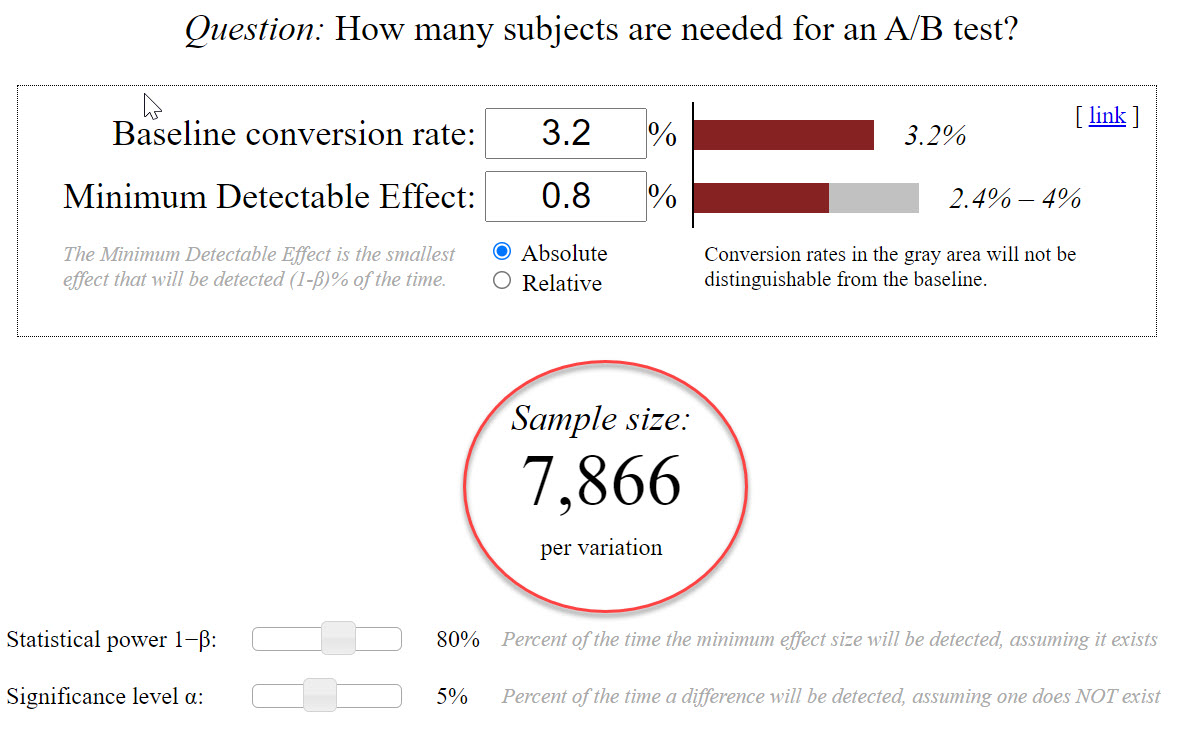

Далее мы собрав необходимое количество данных для выборок, расчитываем p-value, так же в онлайн-калькуляторе по ссылке (https://abtestguide.com/calc/). Результаты выборки:
- контрольная группа: 8732 клиентов, 293 покупателей более 1-го курса
- тестовая группа: 8847 клиентов, 347 покупателей более 1-го курса

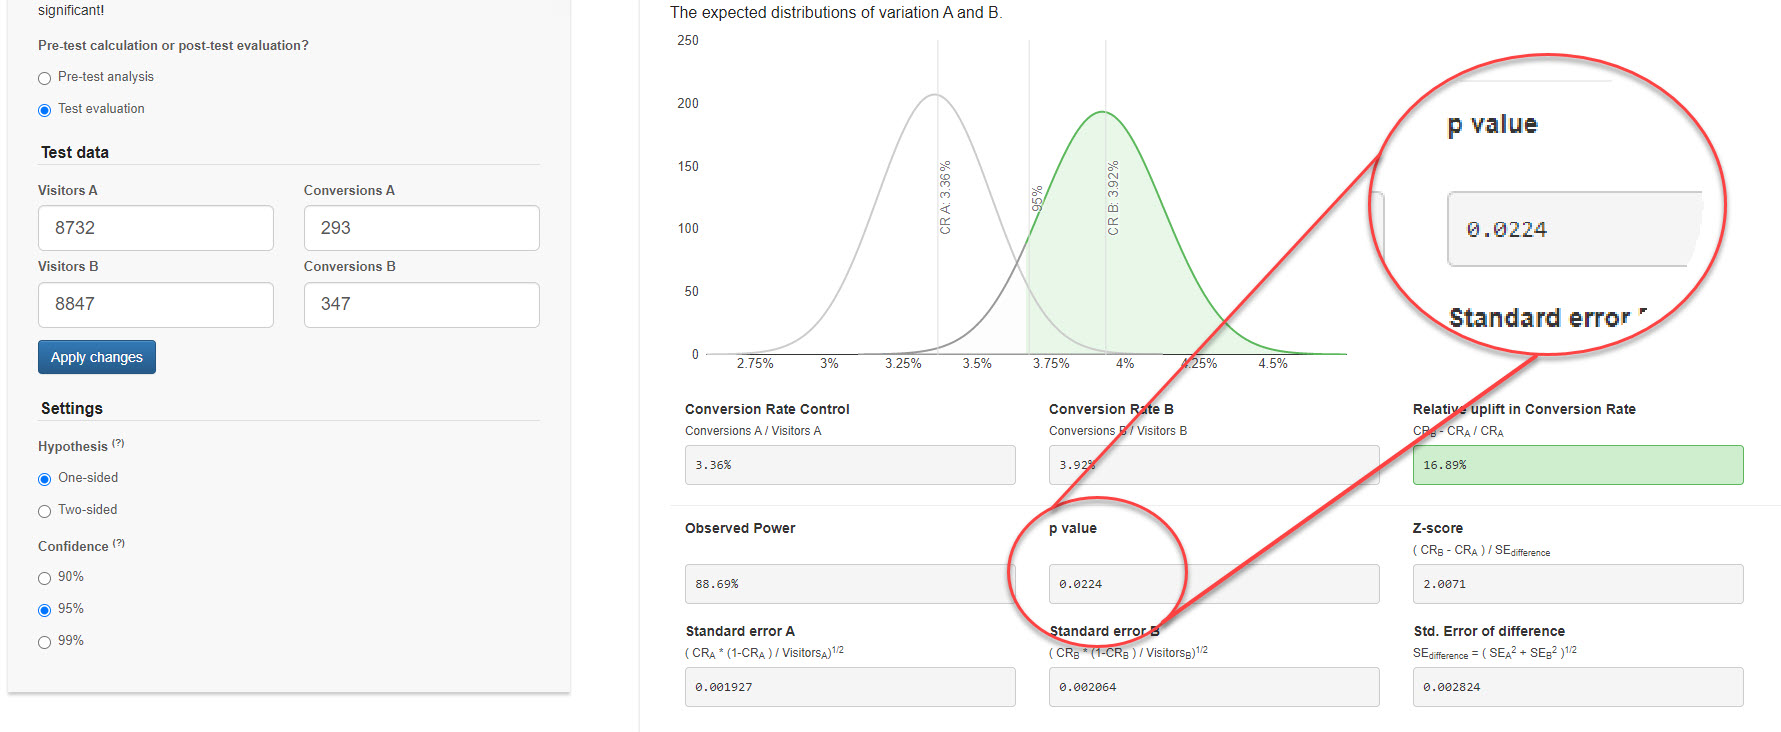

p-value = 0.0224, при текущем значении результаты A/B-теста считаем успешными.

## Выводы:

1. Сформировали таблицу с рекомендациями к покупке популярных курсов для клиентов;
2. Определили минимальный размер групп для A/B-теста;
3. Провели A/B-тест нашего нововведения, тест показал успешные результаты. Наша система будет в дальнейшем применяться в работе онлайн-школы.